In [1]:
# TASKS
# TODO 1. Compare results for using early stopping and not using early stopping, maybe change the stopping criteria and the max patience
# TODO 2. Compare results for using 2 hidden layers as compared to only 1 (this will include a lot of coding changes, but sure helps in understanding the code better)
# TODO 3. Compare results for different hyperparameter values 
# TODO 4. Try to run a sweep locally on your machine using wandb, implementing grid search on chosen hyperparameters

In [54]:
import numpy as np 
import jax 
import jax.numpy as jnp
import time
from jax.example_libraries import optimizers
from sklearn.model_selection import train_test_split
from aux.ECG_utils import DummyArgs, ECGDataset, custom_collate_fn, init_weights_2layer
from aux.training_utils import run_epoch, j_v_prediction_per_sample
from torch.utils.data import DataLoader
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".70"

# parameters taken from the best-performing model after sweeping
args = DummyArgs()
print(args.__dict__)
args.batch_size = 256
args.lr = 0.002
args.tau_mem = 0.15
args.tau_mem_o = 0.01
args.num_hidden = 32
args.weight_gain = 0.4
args.seed = 0 
print(args.__dict__)

{'batch_size': 32, 'lr': 0.005, 'num_epochs': 1, 'tau_mem': 0.15, 'tau_mem_o': 0.1, 'Vth': 1, 'timestep': 0.002777777777777778, 'num_hidden': 64, 'weight_gain': 0.4, 'seed': 0}
{'batch_size': 256, 'lr': 0.002, 'num_epochs': 1, 'tau_mem': 0.15, 'tau_mem_o': 0.01, 'Vth': 1, 'timestep': 0.002777777777777778, 'num_hidden': 32, 'weight_gain': 0.4, 'seed': 0}


In [55]:
# Load delta modulated data
X_train_dm, y_train = np.load('data/x_train_dm_208_multiclass.npy'), np.load('data/y_train_dm_208_multiclass.npy').astype(int) # patient 208
X_test_dm, y_test = np.load('data/x_test_dm_208_multiclass.npy'), np.load('data/y_test_dm_208_multiclass.npy').astype(int) # patient 208

# split the data into train, validation
X_train_dm, X_val_dm, y_train, y_val = train_test_split(X_train_dm, y_train, test_size=0.1, random_state=42)

# print shapes of X_train, X_val, X_test
print(f'\nX_train_dm shape: {X_train_dm.shape},\nX_val_dm shape: {X_val_dm.shape},\nX_test_dm shape: {X_test_dm.shape}')


X_train_dm shape: (2459, 250, 4),
X_val_dm shape: (274, 250, 4),
X_test_dm shape: (304, 250, 4)


In [56]:
# print class distribution
print(f'\nTrain class distribution: {np.unique(y_train, return_counts=True)}')
print(f'Val class distribution: {np.unique(y_val, return_counts=True)}')
print(f'Test class distribution: {np.unique(y_test, return_counts=True)}')


Train class distribution: (array([0, 1, 2, 3]), array([1371,    2,  770,  316]))
Val class distribution: (array([0, 2, 3]), array([139,  93,  42]))
Test class distribution: (array([0, 2, 3]), array([161, 129,  14]))


In [57]:
# remove class 1 from train data
X_train_dm, y_train = X_train_dm[y_train != 1], y_train[y_train != 1]

# print class distribution
print(f'\nTrain class distribution: {np.unique(y_train, return_counts=True)}')
print(f'Val class distribution: {np.unique(y_val, return_counts=True)}')
print(f'Test class distribution: {np.unique(y_test, return_counts=True)}')



Train class distribution: (array([0, 2, 3]), array([1371,  770,  316]))
Val class distribution: (array([0, 2, 3]), array([139,  93,  42]))
Test class distribution: (array([0, 2, 3]), array([161, 129,  14]))


In [58]:
# Balancement of the train dataset

X_208_3 = X_train_dm[y_train == 3]
y_208_3 = y_train[y_train == 3]

X_208_no_3 = X_train_dm[y_train != 3]
y_208_no_3 = y_train[y_train != 3]
print(f'X_208_no_3 shape: {X_208_no_3.shape}')

# concatenate all 4 channels into a single channel
X_208_no_3 = np.concatenate([X_208_no_3[:, :, 0], X_208_no_3[:, :, 1], X_208_no_3[:, :, 2], X_208_no_3[:, :, 3]], axis=1)
print(f'X_208_no_3 shape after concat: {X_208_no_3.shape}')

# use random undersampler to undersample the class 0
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
# print class distribution before undersampling
print(f'Class distribution of the dataset: {np.bincount(y_train)}')
X_208_undersampled, y_208_undersampled = rus.fit_resample(X_208_no_3, y_208_no_3)
print(f'Class distribution of the undersampled dataset: {np.bincount(y_208_undersampled)}')

# de-concatenate all 4 channels into a single channel of X_208_no_3
X_208_undersampled = np.moveaxis(np.stack(np.split(X_208_undersampled, 4, axis=1), axis=0), 0, -1)

# resample class 3 using sklearn.utils.resample to have as many classes as class 2
X_208_3_resampled, y_208_3_resampled = resample(X_208_3, y_208_3, n_samples=np.sum(y_train == 2), random_state=42)
print(f'Class distribution of the resampled class 3: {np.bincount(y_208_3_resampled)}')
print(f'X_208_3_resampled shape: {X_208_3_resampled.shape}')

# concatenate the resampled class 3 with the undersampled dataset
X_208_resampled = np.concatenate([X_208_undersampled, X_208_3_resampled], axis=0)
y_208_resampled = np.concatenate([y_208_undersampled, y_208_3_resampled], axis=0)

# shuffle the dataset
idx = np.arange(X_208_resampled.shape[0])
np.random.shuffle(idx)
X_208_resampled = X_208_resampled[idx]
y_208_resampled = y_208_resampled[idx]

X_208_balanced = X_208_resampled
y_208_balanced = y_208_resampled

# print new class distribution using np.unique
print(f'\nBalanced class distribution: {np.unique(y_208_balanced, return_counts=True)}')

X_train_dm = X_208_balanced
y_train = y_208_balanced

X_208_no_3 shape: (2141, 250, 4)
X_208_no_3 shape after concat: (2141, 1000)
Class distribution of the dataset: [1371    0  770  316]
Class distribution of the undersampled dataset: [770   0 770]
Class distribution of the resampled class 3: [  0   0   0 770]
X_208_3_resampled shape: (770, 250, 4)

Balanced class distribution: (array([0, 2, 3]), array([770, 770, 770]))


In [59]:
train_loader = DataLoader(ECGDataset(X_train_dm, y_train),
                          batch_size=args.batch_size, shuffle=True, 
                          collate_fn=custom_collate_fn, drop_last=True)
val_loader = DataLoader(ECGDataset(X_val_dm, y_val), batch_size=args.batch_size, 
                        shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(ECGDataset(X_test_dm, y_test), batch_size=args.batch_size, 
                         shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

In [60]:
# initialize the weights

out_multiclass_p208 = 4

key = jax.random.PRNGKey(0)
key, w_original = init_weights_2layer(key, 4, args.num_hidden, out_multiclass_p208, args.weight_gain)

# initialize the optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=args.lr)
opt_state = opt_init(w_original)

In [61]:
early_stopping = False

In [62]:
def train(hyperparams, n_epochs, opt_state, get_params, opt_update):

    print(f'batch_size = {args.batch_size}')
    key = jax.random.PRNGKey(0)
    best_train_acc = 0.000001
    best_train_f1 = 0.000001
    max_patience = 60
    patience = 0  # Early stopping
    print(f'{"Epoch": <6} | '
          f'{"Train loss": <15} | '
          f'{"Train acc": <15} | '
          f'{"Val acc": <15} | '
          f'{"Test acc": <15} | '
          f'{"Test Precision": <15} | '
          f'{"Test Recall": <15} | '
          f'{"Test F1": <15} | '
          f'{"Time": <15}')
    for e in range(n_epochs):
        epoch_start = time.time()
        key, opt_state, train_loss, train_acc, train_prec, train_rec, train_f1 = (
            run_epoch(key, train_loader, hyperparams, opt_state, get_params, 
                      e, opt_update)
        )
        key, _, val_loss, val_acc, val_prec, val_rec, val_f1 = (
            run_epoch(key, val_loader, hyperparams, opt_state, get_params)
        )
        time_epoch = time.time()
    
        key_test = jax.random.PRNGKey(0)
        _, _, test_loss, test_acc, test_prec, test_rec, test_f1 = (
            run_epoch(key_test, test_loader, hyperparams, opt_state, get_params)
        )
        if early_stopping and (train_acc > best_train_acc or train_f1 > best_train_f1):
            if ((train_acc - best_train_acc)/best_train_acc < 0.01 and train_acc > best_train_acc) or (train_f1 > best_train_f1 and (train_f1 - best_train_f1)/best_train_f1 < 0.01):
                patience += 1
                if patience == max_patience:
                    print(f'Early stopping at epoch {e}')
                    break
            else:
                best_train_acc = train_acc
                best_train_f1 = train_f1
                
                w_best = get_params(opt_state)
                opt_state_best = opt_state
                patience = 0
                #key_test 
                #jnp.save(f'weights/w_best.npy', w_best)    
            if e % 10 == 0:
                print(f'{e : <6} | '
                        f'{train_loss:.4f}{"":<9} | '
                        f'{train_acc:.4f}{"":<9} | '
                        f'{val_acc:.4f}{"":<9} | '
                        f'{test_acc:.4f}{"":<9} | '
                        f'{test_prec:.4f}{"":<9} | '
                        f'{test_rec:.4f}{"":<9} | '
                        f'{test_f1:.4f}{"":<9} | '
                        f'{time_epoch - epoch_start:.2f}{"":<9} | '
                        f'{patience:.2f}')
        else:
            if e % 10 == 0:
                print(f'{e : <6} | '
                        f'{train_loss:.4f}{"":<9} | '
                        f'{train_acc:.4f}{"":<9} | '
                        f'{val_acc:.4f}{"":<9} | '
                        f'{test_acc:.4f}{"":<9} | '
                        f'{test_prec:.4f}{"":<9} | '
                        f'{test_rec:.4f}{"":<9} | '
                        f'{test_f1:.4f}{"":<9} | '
                        f'{time_epoch - epoch_start:.2f}{"":<9} | '
                        f'{patience:.2f}')
            if early_stopping:
                    patience += 1
                    if patience == max_patience:
                        print(f'Early stopping at epoch {e}')
                        break
            
    return best_train_acc, opt_state, get_params, best_train_acc, train_loss, train_acc, val_acc, test_acc, test_prec, test_rec, test_f1, patience

In [64]:
hyperparams = (args.tau_mem, args.tau_mem_o, args.Vth, args.timestep)
_, opt_state, get_params, best_train_acc, train_loss, train_acc, val_acc, test_acc, test_prec, test_rec, test_f1, patience = train(hyperparams, 401, opt_state, get_params, opt_update)

batch_size = 256
Epoch  | Train loss      | Train acc       | Val acc         | Test acc        | Test Precision  | Test Recall     | Test F1         | Time           
0      | 0.4468          | 0.8893          | 0.9023          | 0.9258          | 0.7779          | 0.9214          | 0.8096          | 0.16          | 0.00
10     | 0.4190          | 0.8967          | 0.8945          | 0.9570          | 0.8343          | 0.9408          | 0.8712          | 0.14          | 0.00
20     | 0.4256          | 0.8980          | 0.8945          | 0.9336          | 0.7916          | 0.9259          | 0.8274          | 0.14          | 0.00
30     | 0.4384          | 0.8898          | 0.9102          | 0.9492          | 0.8305          | 0.9662          | 0.8735          | 0.14          | 0.00
40     | 0.4259          | 0.8915          | 0.9141          | 0.9453          | 0.8036          | 0.9030          | 0.8360          | 0.14          | 0.00
50     | 0.4106          | 0.9032          | 0.8828 

# Debug

In [65]:
from aux.debug import plot_net, out_debug, plot_Vh1
batch_spikes, batch_labels = next(iter(test_loader))

In [66]:
w = get_params(opt_state)
*state, out, loss, pred = (
    out_debug(batch_spikes, batch_labels, hyperparams, w)
)

(S_h1, I_h1, V_h1), (S_h2, I_h2, V_h2), (S_o, I_o, V_o) = state[0]

# print shapes
print(f'batch_spikes shape: {batch_spikes.shape}, batch_labels shape: {batch_labels.shape}')
print(f'S_h1 shape: {S_h1.shape}, I_h1 shape: {I_h1.shape}, V_h1 shape: {V_h1.shape}')
print(f'S_h2 shape: {S_h2.shape}, I_h2 shape: {I_h2.shape}, V_h2 shape: {V_h2.shape}')
print(f'S_o shape: {S_o.shape}, I_o shape: {I_o.shape}, V_o shape: {V_o.shape}')
print(f'out shape: {out.shape}, loss shape: {loss.shape}, pred shape: {pred.shape}')

# print pred
offset = 50
print(f'\npred: {pred[offset:(offset+25)]}')
print(f'lbls: {batch_labels[offset:(offset+25)]}')
print(f'same: {np.equal(pred, batch_labels)[offset:(offset+25)].astype(int)}')

# print manual accuracy
print(f'\nmanual accuracy: {np.mean(np.equal(pred, batch_labels))}')

loss: 0.26668232679367065, acc: 0.9453125
batch_spikes shape: (256, 250, 4), batch_labels shape: (256,)
S_h1 shape: (256, 250, 32), I_h1 shape: (256, 250, 32), V_h1 shape: (256, 250, 32)
S_h2 shape: (256, 250, 16), I_h2 shape: (256, 250, 16), V_h2 shape: (256, 250, 16)
S_o shape: (256, 250, 4), I_o shape: (256, 250, 4), V_o shape: (256, 250, 4)
out shape: (256, 4), loss shape: (), pred shape: (256,)

pred: [3 2 2 0 0 2 0 0 2 2 0 0 2 0 2 2 0 0 2 0 0 2 0 0 2]
lbls: [0 2 2 0 0 2 0 0 2 2 0 0 2 0 3 2 0 0 2 0 0 2 0 0 2]
same: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]

manual accuracy: 0.9453125


w_original[0] == w[0]: False
loss: 1.4233994483947754, acc: 0.00390625
loss: 0.26668232679367065, acc: 0.9453125


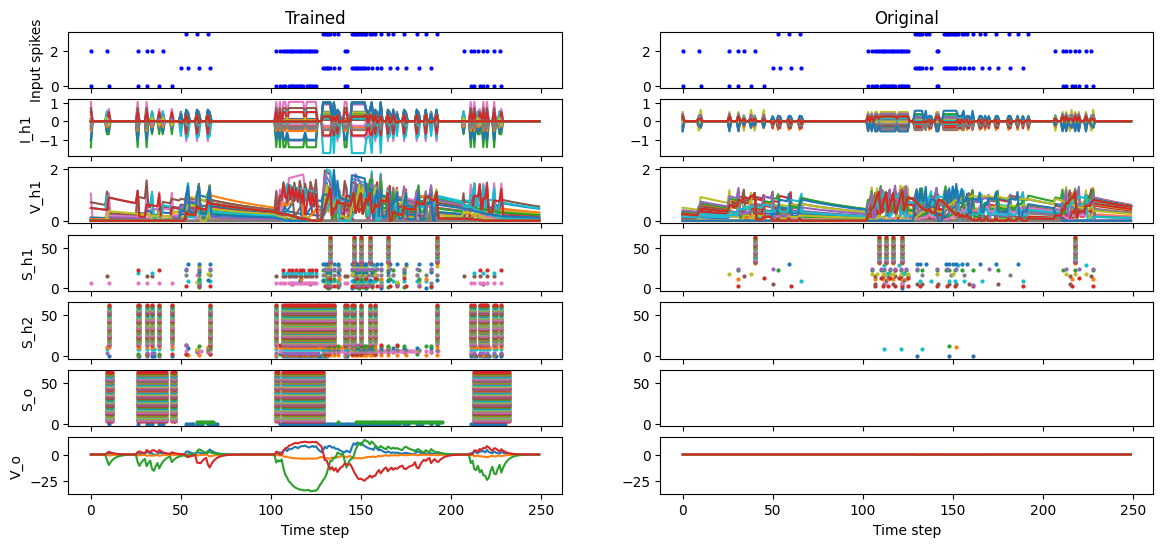

In [67]:
plot_net(get_params(opt_state), w_original, batch_spikes, batch_labels, hyperparams, 12)

loss: 0.26668232679367065, acc: 0.9453125


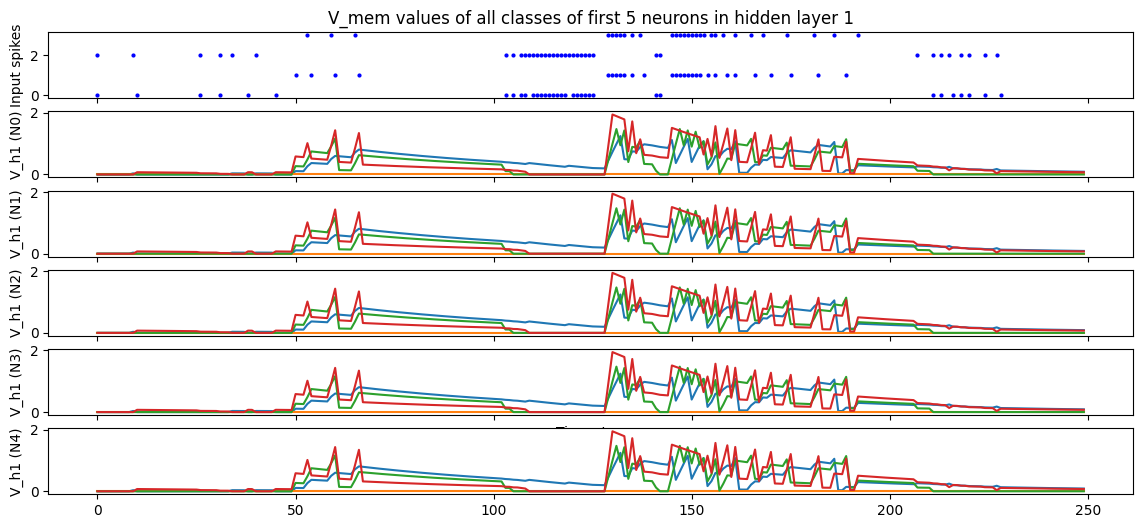

In [68]:
plot_Vh1(get_params(opt_state), batch_spikes, batch_labels, hyperparams, 12)

In [69]:
w = get_params(opt_state)
print(len(w))

print(w[0].shape)

print(w[0])

5
(32, 4)
[[-4.37055118e-02  1.09042354e-01  3.62278484e-02  1.64005667e-01]
 [-2.85365850e-01 -7.02473847e-03 -8.78982171e-02 -4.80766445e-01]
 [-6.12354800e-02  2.70276576e-01 -1.41926780e-01  2.30000421e-01]
 [ 7.30387866e-02  5.17799079e-01 -8.85966569e-02  4.64071512e-01]
 [-4.14606482e-01  4.11727279e-01 -6.38097405e-01  5.22145890e-02]
 [ 3.42901945e-02  1.52987733e-01  8.95108208e-02  1.25283301e-01]
 [ 6.64815962e-01  2.56667882e-01  3.84407520e-01 -1.08188128e+00]
 [ 2.85444446e-02  3.84942412e-01 -3.75447541e-01  7.21792653e-02]
 [ 2.30445415e-01  2.65232444e-01 -2.78256714e-01  2.40910605e-01]
 [-1.15112416e-01  4.94055361e-01  6.32173121e-02  5.13473928e-01]
 [ 2.47315750e-01  9.37727541e-02 -1.31840393e-01  1.77400187e-01]
 [ 1.85556963e-01  1.00036070e-01 -1.18367061e-01  1.58490166e-01]
 [-7.06460953e-01  3.66412789e-01 -7.09499836e-01  3.90905328e-02]
 [ 1.07439362e-01 -3.06818604e-01 -1.19703665e-01  5.18671155e-01]
 [-3.52739751e-01 -5.68712465e-02 -1.06974535e-01 -2

loss: 1.4233994483947754, acc: 0.00390625


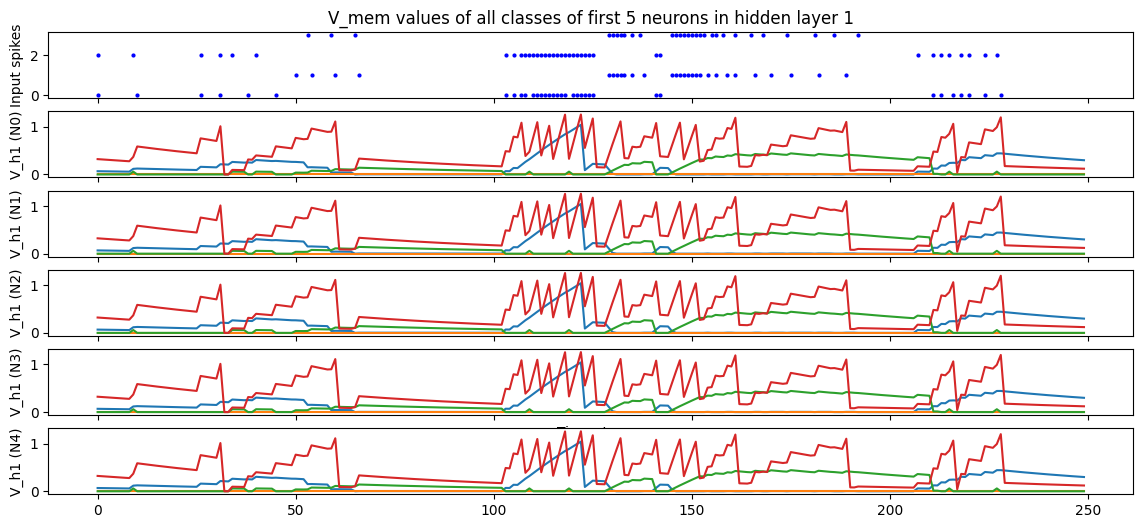

In [70]:
plot_Vh1(w_original, batch_spikes, batch_labels, hyperparams, 12)

(304, 250, 4)
(304, 4)
(304,)


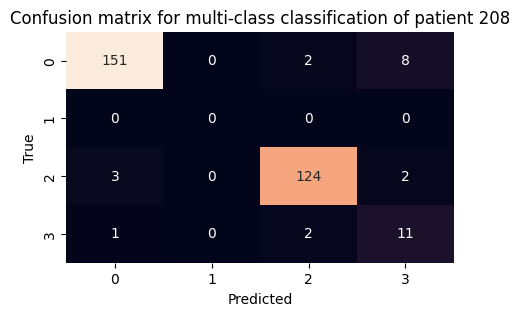


Class  | Recall   | Precision | Specificity | F1    
0      | 0.937888 | 0.9741935 | 0.972027972 | 0.955696
2      | 0.961240 | 0.9687500 | 0.975903614 | 0.964981
3      | 0.785714 | 0.5238095 | 0.965517241 | 0.628571

accuracy: 0.9407894736842105


In [71]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

state = j_v_prediction_per_sample(get_params(opt_state), X_test_dm, hyperparams)
V_mem = state[2][2]
print(V_mem.shape) # (batch_size, sim_len ,out_dim)
max_per_class = jnp.max(V_mem, axis=1)
print(max_per_class.shape)
y_pred = jnp.argmax(max_per_class, axis=1)
print(y_pred.shape)

cm_dim = out_multiclass_p208 # class 1 is just left empty

# plot normalized confusion matrix manually without sklearn
cm = np.zeros((cm_dim, cm_dim))
for i in range(len(y_pred)):
    cm[y_test[i], y_pred[i]] += 1
#cm = cm / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_dim)], columns = [i for i in range(cm_dim)])
plt.figure(figsize = (5,3))
sns.heatmap(df_cm, annot=True, fmt='g', cbar=False) # cmap='Blues'
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for multi-class classification of patient 208')
plt.show()

# print f1, precision, recall without classification report
precision = np.zeros(cm_dim)
recall = np.zeros(cm_dim)
specificity = np.zeros(cm_dim)
f1 = np.zeros(cm_dim)

# formula for specificity 
# specificity = TN / (TN + FP) = TN / N = 1 - FPR

for i in range(out_multiclass_p208):
    precision[i] = cm[i,i] / cm[:,i].sum() if cm[:,i].sum() != 0 else np.nan
    recall[i] = cm[i,i] / cm[i,:].sum() if cm[i,:].sum() != 0 else np.nan
    # calculate specificity
    TN = cm[:i,:i].sum() + cm[i+1:,i+1:].sum()
    FP = cm[:i,i].sum() + cm[i+1:,i].sum()
    specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else np.nan
    f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else np.nan

# print recall, precision, specificity, f1 in a table for each class
print(f'\n{"Class": <6} | {"Recall": <8} | {"Precision": <9} | {"Specificity": <9} | {"F1": <6}')
for i in range(cm_dim):
    if i == 1:
        continue
    print(f'{i : <6} | {recall[i]:.6f} | {precision[i]:.7f} | {specificity[i]:.9f} | {f1[i]:.6f}')

# print ovreall accuracy
accuracy = np.mean(np.equal(y_pred, y_test))
print(f'\naccuracy: {accuracy}')

In [72]:
# # get weights
# w = get_params(opt_state)
# run_id = 'run0001'

# # save weights of current model in for loop
# for i in range(len(w)):
#     #if file does nor exist, create one
#     if not os.path.exists('weights'):
#         os.makedirs('weights')
#     jnp.save(f'weights/'+run_id+'_w_'+str(i)+'.npy', w[i])